In [ ]:
!pip install scikit-plot

In [ ]:
!pip install plot_helper

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
from sklearn.metrics import f1_score,confusion_matrix,roc_curve,roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling1D,Input,Conv2D,CuDNNLSTM,Activation
from keras.models import Model
from keras.regularizers import l1,l2
from keras.initializers import he_normal,glorot_normal
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import requests
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image
import datetime
from sklearn.utils import shuffle
from keras.applications import xception
import scikitplot as skplt
import importlib
import plot_helper as plt_hlp
importlib.reload(plt_hlp)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/case_study_2/input/inception_features.csv')

In [ ]:
f = data.columns[:57]
data = data[f]

In [ ]:
df = data[data.dank_level==0].sample(n=946,replace=False)
data = data[data['upvote ratio']>0.0016]
data = pd.concat([data,df],ignore_index=True)
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
x = data.drop(['id','thumbnail.thumbnail','title','text_words','processed_words','url','dank_level','Text','media'],axis=1)
y = data['dank_level']

### Checking Feature Importance and Feature Selection

In [ ]:
categorical_cols = ['is_nsfw','subreddit','Time_of_day','off-white', 'aqua', 'mustard','black', 'purple', 'red-brown', 'dust-brown', 'gray-blue', 'orange',
                    'salmon', 'dark-green', 'pink', 'white', 'yellow-green','bright-yellow', 'medium_sea_green', 'dodgerblue', 'plum','saddlebrown',
                    'medium_violet_red', 'dark_slate_blue', 'midnight_blue','cadet_blue', 'medium_spring_green', 'olive', 'tomato', 'forestgreen',
                    'thick_pinkdesaturated_orange']

In [ ]:
params = {
    'boosting_type': 'gbdt','objective': 'regression','metric': {'rmse'},'subsample': 0.2,'learning_rate': 0.9,'feature_fraction': 0.9,'bagging_fraction': 0.9,'alpha': 0.1,'lambda': 0.1
}

folds = 3
seed = 41 #666
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for train_index, val_index in kf.split(x):
    train_x = x.iloc[train_index]
    val_x = x.iloc[val_index]
    train_y = y.iloc[train_index]
    val_y = y.iloc[val_index]
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=10, 
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds= 10,
                    verbose_eval=10) 
    models.append(gbm)

Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 0.0234597	valid_1's rmse: 0.017225
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 0.0234597	valid_1's rmse: 0.017225
Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 0.0171317	valid_1's rmse: 0.00892287
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 0.0171317	valid_1's rmse: 0.00892287
Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 0.0231312	valid_1's rmse: 0.0659037
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 0.0231312	valid_1's rmse: 0.0659037


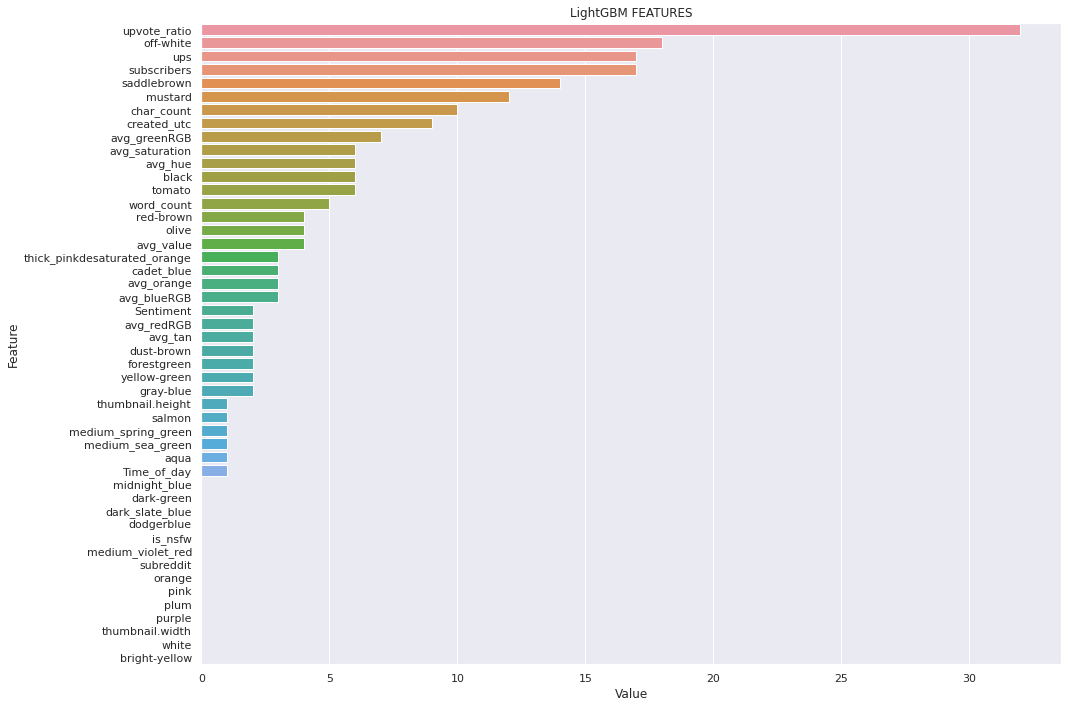

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

In [ ]:
drop_features =['bright-yellow','dark_slate_blue','dodgerblue','is_nsfw','medium_violet_red','midnight_blue','dark-green','orange',
                'pink','plum','yellow-green','purple','subreddit','thumbnail.width','white','id','thumbnail.thumbnail','title','text_words',
                'processed_words','url']

In [ ]:
data = data.drop(drop_features,axis=1)

In [ ]:
corr_all=data.drop(['Text','media'],axis=1).corr()

In [ ]:
def find_corr_pairs(corr,thrsh):
    
    """
    find high correlation column pairs in corr_all
    ======================================
    input: 
    corr - (df)- correlation matrix generated by pandas
    thrsh - (float) threshold value to consider correlation as high so that it is included in the output 
    output:
    high_corr_pairs - (list) list of tuples of the two-column names and their correlation. corr> thrsh
    """
    high_corr_pairs = []
    # same as input 'corr' but the upper -triangle half of the matrix is zeros ( for convenience only) 
    corr_diag = pd.DataFrame(np.tril(corr.values), columns=corr.columns, index = corr.index)

    # check  the correlation between every pair of columns in the corr and keeps the high ones
    for col_num , col in enumerate(corr_diag):
        col_corr=corr_diag[col].iloc[col_num+1:] # this slicing ensures ignoring self_corr and duplicates due to symmetry
        # bool mask for pairs with high corr with col
        mask_pairs = col_corr.apply(lambda x: abs(x))>thrsh 
        idx_pairs=col_corr[mask_pairs].index

        # create list of high corr pairs
        for idx , corr in zip(idx_pairs,col_corr[mask_pairs].values):
            high_corr_pairs.append((col, idx, corr))
    
    return high_corr_pairs

In [ ]:
corr_pairs=find_corr_pairs(corr_all,0.8)
for c in corr_pairs:
    print(c)

('word_count', 'char_count', 0.9448083171841072)
('avg_value', 'avg_redRGB', 0.9309103555686603)
('avg_value', 'avg_greenRGB', 0.9630443700519383)
('avg_value', 'avg_blueRGB', 0.9555036997039955)
('avg_redRGB', 'avg_greenRGB', 0.9598813469178364)
('avg_redRGB', 'avg_blueRGB', 0.8843368477967326)
('avg_greenRGB', 'avg_blueRGB', 0.9438475426497863)
('gray-blue', 'cadet_blue', 0.8004205933474323)


In [ ]:
data = data.drop(['word_count','avg_redRGB','avg_value','avg_blueRGB','gray-blue'],axis=1)

In [ ]:
df = df.dropna()

### VIF 

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
  
print(vif_data)

                         feature         VIF
0                    created_utc  153.197521
1                    subscribers    1.752799
2               thumbnail.height    1.049765
3                            ups    4.813354
4                   upvote ratio    4.078375
5                     dank_level    2.372704
6                    Time_of_day    1.019571
7                      Sentiment    1.054714
8                     char_count    1.105863
9                        avg_hue    1.991118
10                avg_saturation    3.245920
11                  avg_greenRGB    3.357393
12                       avg_tan    1.134587
13                    avg_orange    1.073575
14                     off-white    1.124797
15                          aqua    1.017957
16                       mustard    1.081547
17                         black    2.208994
18                     red-brown    1.166386
19                    dust-brown    1.045623
20                        salmon    2.805412
21        

In [ ]:
drop_features = ['ups','upvote ratio','avg_saturation','avg_greenRGB','black','salmon','tomato']

In [ ]:
data = data.drop(drop_features,axis=1)

In [ ]:
data = data.dropna()

### Correlation Matrix

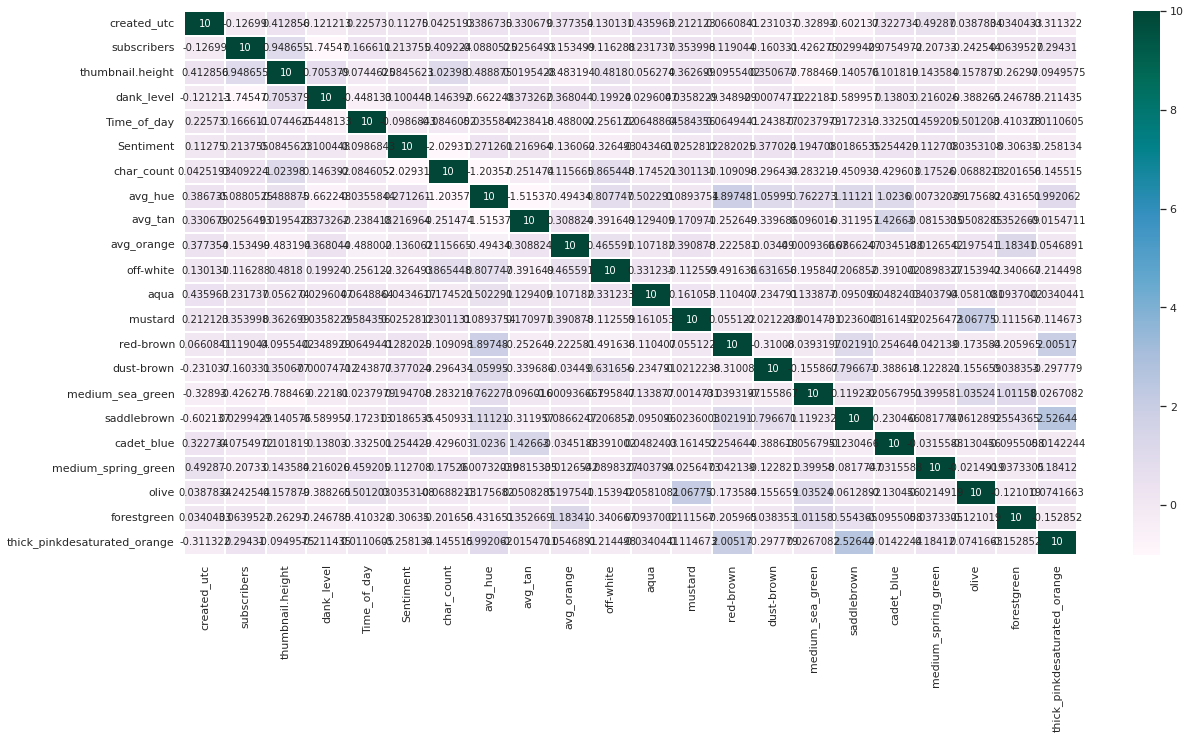

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(data.drop(['Text','media'],axis=1).corr()*10,vmin=-1,vmax=10,linewidths=1,annot=True,annot_kws={"size": 10},fmt="g",ax=ax,cmap='PuBuGn')

In [ ]:
X = data.drop(['dank_level'],axis=1)
y = data['dank_level']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)

### Building Xception pretrained model for Image data

In [ ]:
xception = xception.Xception(weights='imagenet',input_shape=(299, 299, 3))

91897856/91884032 [==============================] - 0s 0us/step


In [ ]:
def image_data(df):
    ls = []
    for url in tqdm(df.media.values): 
        response = requests.get(url, stream=True)
            #opening the image
        image= np.array(Image.open(response.raw))
        image= np.resize(image,(299,299,3))
        image = image.astype('float32')
        image /= 255  
        ls.append(image)   
    return ls 

train_image = image_data(x_train)
test_image = image_data(x_test)

100%|██████████| 563/563 [03:46<00:00,  2.48it/s]


### Finding Fasttext word embeddings for Text data

In [ ]:
max_words = 10000
max_len = 225
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train['Text'].astype(str))
train_sequences = tok.texts_to_sequences(x_train['Text'].astype(str))
train_sequences_matrix = pad_sequences(train_sequences,maxlen=max_len)
word_index = tok.word_index

test_sequences = tok.texts_to_sequences(x_test['Text'].astype(str))
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

print("unique words : {}".format(len(word_index)))

unique words : 5219


In [ ]:
def load_fasttext():
        print('loading word embeddings...')
        embeddings_index = {}
        f = open('/content/drive/MyDrive/wiki-news-300d-1M.vec',encoding='utf-8')
        for line in tqdm(f):
            values = line.strip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print('found %s word vectors' % len(embeddings_index))
    
        return embeddings_index

embeddings_index=load_fasttext()

loading word embeddings...


999995it [01:09, 14421.95it/s]

found 999995 word vectors


In [ ]:
embedding_mat = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vec = embeddings_index.get(word)
    if embedding_vec is not None:
        embedding_mat[i] = embedding_vec

In [ ]:
len(np.where(~embedding_mat.any(axis=1))[0])

1587

### Normalizing other numerical features

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train.drop(['media','Text'],axis=1))
x_train_numerical_features = scaler.transform(x_train.drop(['media','Text'],axis=1))
x_test_numerical_features = scaler.transform(x_test.drop(['media','Text'],axis=1))

In [ ]:
x_test_numerical_features.shape

(563, 21)

### Building Fusion model with fasttext word embeddings lstm model and xception pretrained model and with other numerical features

In [ ]:
tf.keras.backend.clear_session()
input_text = Input(name='input_text',shape=[train_sequences_matrix.shape[1]])
layer = Embedding(len(word_index) + 1,300,weights=[embedding_mat],input_length=max_len,trainable=False)(input_text)
layer = LSTM(64,return_sequences=True)(layer)
flatten_text = Flatten()(layer)

input_image = Input(name='input_image',shape=(299,299,3))
layer = Conv2D(filters=64, kernel_size=3, strides=(4, 4), activation='relu')(input_image)
layer= Conv2D(filters=64, kernel_size=3, strides=(5, 5), activation='relu')(layer)
flatten_image = Flatten()(layer)

input_numerical_features = Input(name='input_features',shape=[x_train_numerical_features.shape[1]])
dense = Dense(16,activation='relu',kernel_initializer='he_normal')(input_numerical_features)

concat = concatenate([flatten_text,flatten_image,dense])

dense = Dense(128,activation='relu',kernel_initializer='he_normal')(concat)
dropout = Dropout(0.3)(dense)
dense = Dense(64,activation='relu',kernel_initializer='he_normal')(dropout)
batch = BatchNormalization()(dense)
dropout = Dropout(0.2)(batch)
dense = Dense(32,activation='relu',kernel_initializer='he_normal')(dropout)
output = Dense(1,activation='sigmoid')(dense)
model = Model(inputs=[input_text,input_image,input_numerical_features],outputs=output) 

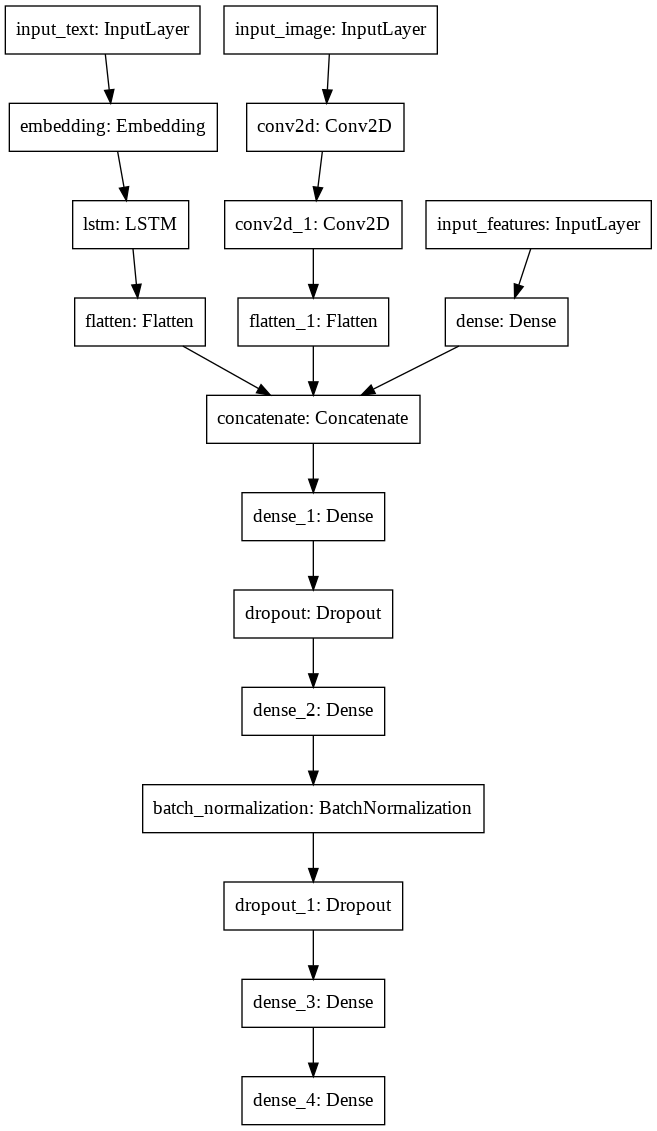

In [ ]:
plot_model(model)

In [ ]:
log_dir="/content/"  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.compile(optimizer=Adam(learning_rate=0.0006,decay = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([train_sequences_matrix,np.array(train_image,np.float32),x_train_numerical_features],y_train,validation_split=0.2,epochs=20,batch_size=128,callbacks=[earlystop,checkpoint,tensorboard_callback],verbose=1)

Epoch 1/20
9/9 [==============================] - 23s 284ms/step - loss: 0.8146 - accuracy: 0.5172 - val_loss: 1.3873 - val_accuracy: 0.5399

Epoch 00001: val_loss improved from inf to 1.38735, saving model to weights.hdf5
Epoch 2/20
9/9 [==============================] - 1s 81ms/step - loss: 0.7866 - accuracy: 0.5219 - val_loss: 0.9955 - val_accuracy: 0.5399

Epoch 00002: val_loss improved from 1.38735 to 0.99548, saving model to weights.hdf5
Epoch 3/20
9/9 [==============================] - 1s 79ms/step - loss: 0.7468 - accuracy: 0.5410 - val_loss: 0.6973 - val_accuracy: 0.5551

Epoch 00003: val_loss improved from 0.99548 to 0.69731, saving model to weights.hdf5
Epoch 4/20
9/9 [==============================] - 1s 80ms/step - loss: 0.7400 - accuracy: 0.5353 - val_loss: 0.7400 - val_accuracy: 0.5399

Epoch 00004: val_loss did not improve from 0.69731
Epoch 5/20
9/9 [==============================] - 1s 80ms/step - loss: 0.7386 - accuracy: 0.5315 - val_loss: 0.7407 - val_accuracy: 0.52

In [ ]:
predictions = model.predict([test_sequences_matrix,np.array(test_image,np.float32),x_test_numerical_features])

In [ ]:
predict = np.array([])
for proba in predictions:
    if proba>=0.5:
        predict = np.append(predict,np.array([1]),axis=0)
    else:
        predict = np.append(predict,np.array([0]),axis=0)

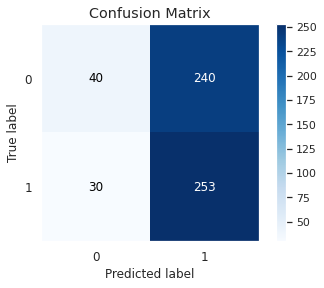

In [ ]:
matrix = skplt.metrics.plot_confusion_matrix(y_test,predict,labels=[0,1])

In [ ]:
print("Accuracy:",accuracy_score(y_test, predict))
print("Precision: ",precision_score(y_test,predict,average='weighted'))
print("Recall: ",recall_score(y_test, predict,average='weighted')) 
print("F-1 Score: ",f1_score(y_test, predict,average='weighted'))

Accuracy: 0.5204262877442274
Precision:  0.5421513984414125
Recall:  0.5204262877442274
F-1 Score:  0.4414449469887019


No handles with labels found to put in legend.


AUC= 0.5596920747097426


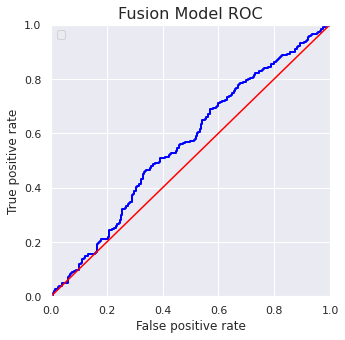

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1, sample_weight=None)
auc = roc_auc_score(y_test, predictions, sample_weight=None)
print("AUC=", auc)

# plot ROC curves 
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,linewidth=2.0,color='blue')
plt.plot([0,1],[0,1],color='red')
plt.legend()
plt.xlabel('False positive rate',fontsize=12) 
plt.ylabel('True positive rate',fontsize=12)
plt.xlim([0,1]); plt.ylim([0,1])
plt.title('Fusion Model ROC', fontsize=16)
plt.show()

In [2]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model", "Data","Pretrained Model","Accuracy", "Precision", "Recall","F1-Score","AUC"])
  
# Add rows
myTable.add_row(["LSTM", "Text","Fast Text", "53.14 %","53.09 %","49.89 %","51.44 %","53.93 %"])
myTable.add_row(["NeuralNetwork","Image", "Xception", "51.16 %","51.20 %","51.16 %","50.90 %","54.33 %"])
myTable.add_row(["NeuralNetwork","Text and Image","Fast Text and Xception","55.63 %","58.89 %","55.63 %","51.15 %","56.96%"])
myTable.add_row(["NeuralNetwork","Text and Image and other numerical features","Fast Text and Xception","52.04 %","54.21 %","52.04 %","44.14 %","55.96%"])

print(myTable)

+---------------+---------------------------------------------+------------------------+----------+-----------+---------+----------+---------+
|     Model     |                     Data                    |    Pretrained Model    | Accuracy | Precision |  Recall | F1-Score |   AUC   |
+---------------+---------------------------------------------+------------------------+----------+-----------+---------+----------+---------+
|      LSTM     |                     Text                    |       Fast Text        | 53.14 %  |  53.09 %  | 49.89 % | 51.44 %  | 53.93 % |
| NeuralNetwork |                    Image                    |        Xception        | 51.16 %  |  51.20 %  | 51.16 % | 50.90 %  | 54.33 % |
| NeuralNetwork |                Text and Image               | Fast Text and Xception | 55.63 %  |  58.89 %  | 55.63 % | 51.15 %  |  56.96% |
| NeuralNetwork | Text and Image and other numerical features | Fast Text and Xception | 52.04 %  |  54.21 %  | 52.04 % | 44.14 %  |  55.96% |

# Conclusion

* From the results it is clear that Image data has high predictive power than text data.
* Fusion data(both text and image data) has high predictive power but when combining other features the Predictive power was decreasing.
* So the predictive power is Image and Text data > Image and Text data along with other related Features > Image data > Text data